### Create the data

https://cs231n.github.io/convolutional-networks/
https://medium.com/apache-mxnet/multi-channel-convolutions-explained-with-ms-excel-9bbf8eb77108

In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
from cycler import cycler
import matplotlib.style
import matplotlib as mpl
from mpl_toolkits import mplot3d 

In [2]:
import matplotlib
print(matplotlib.get_configdir())
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
                                  

/home/sunyue/.config/matplotlib


nn.Module comes in handy while writing many DL model. For example when you are trying to code Maxout Network as defined in the paper [Maxout Networks] (https://arxiv.org/pdf/1302.4389.pdf 44).
https://github.com/pytorch/pytorch/commit/c7c8aaa7f040dd449dbc6aca9204b2f943aef477
https://discuss.pytorch.org/t/multiple-parallel-fully-connected-layers-type-torch-cuda-floattensor-but-found-type-torch-floattensor/37810
https://www.geeksforgeeks.org/single-neuron-neural-network-python/
https://rhettinger.wordpress.com/2011/05/26/super-considered-super/


In [3]:
%matplotlib notebook
import glob, os, os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import bisect
import scipy.sparse as sparse  #for baseline subtraction
from matplotlib import rc
# rc('mathtext', default='regular')
import h5py
# torch.set_printoptions(threshold=100000)
# plt.style.use('science')

In [4]:
hfont = {'fontname':'Helvetica'}

In [5]:
'''Definitions'''

def gaussian(x, x0, r, a, b):
    y = b + a*np.exp(-(x-x0)**2/(2*r**2))
    return y

def PseudoVoigtFunction(WavNr, Pos, Amp, GammaL, FracL):
    SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter  for the Gaussian distribution from GammaL (coupled in Pseudo-Voigt)
    LorentzPart = Amp / np.pi * (GammaL / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
    GaussPart = Amp / (np.sqrt(2*np.pi) * SigmaG) * np.exp( -(WavNr - Pos)**2 / (2 * SigmaG**2)) # Gaussian distribution
    Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts (or distributions)
    return Fit

#baseline subtraction based on Asymetric Least Square Smoothing
#https://zanran_storage.s3.amazonaws.com/www.science.uva.nl/ContentPages/443199618.pdf
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = sparse.linalg.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# Function which extracts the number of all XYfiles in the directory.    
run_no=0
def get_number_XYfiles(run_no):
    directory = os.listdir('data/')
    number_XYfiles = run_no
    for Dir in directory:
        number_XYfiles = number_XYfiles+1
    return(number_XYfiles)

In [6]:
# show the number of XYfiles found in the directory
total_XYfiles = get_number_XYfiles(run_no)
print(total_XYfiles)
total_XYfiles=350 #[Pt=1084, MgFeOB1_263]
print('The number of XYfiles within the chosen run is:', total_XYfiles)
%pwd
%mkdir -p ClassificationFigures
save_figures_to = '../ClassificationFigures/'

350
The number of XYfiles within the chosen run is: 350


In [17]:
save_figures_to

'../ClassificationFigures/'

In [7]:
'''make sure that you have the right command directory selected'''
%cd /gpfs/exfel/data/user/sunyue/Downloads/Brockhauser_Sandor/L2_Beamtime2019_Fe200culet_fe80mg20/XY/
theta = [] 
I = []
baseline = []
Icorrect = []

test_y=total_XYfiles-2
for run_no in range(1,0+total_XYfiles):
    fileNO = str(run_no).zfill(4) 
    fname = 'l2_fe80mg20_ramp_00001_m1_'+str(run_no).zfill(4)+'.xy'
    thetas, Is = np.loadtxt(fname, skiprows=25, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is
    I.append(Is) # attaches a new array each time to a copy of previous, not really necessary here
    idx1 = 0
    idx2 = 4050
#background subtraction
#parameters lam and p have to be adjusted by hand!
#try 10**2 < lam < 10**9
#    0.001 <  p  < 0.1
    lam = 100000
    p = 0.002
    baselines = baseline_als(Is[idx1:idx2], lam, p)
    baseline.append(baselines)
    Icorrected = Is[idx1:idx2] - baselines
    Icorrect.append(Icorrected)
#    if (run_no==15): 
#        print(thetas.size, Is.shape,type(I),np.shape(I),len(Icorrected),len(baselines),sep='\n')
    thetas = thetas[idx1:idx2]
    theta.append(thetas)

/gpfs/exfel/data/user/sunyue/Downloads/Brockhauser_Sandor/L2_Beamtime2019_Fe200culet_fe80mg20/XY


In [8]:
print(theta[0].shape,np.size(theta),len(theta),np.size(theta[0]))

(4023,) 1404027 349 4023


In [9]:
349*4023

1404027

In [10]:
plt.figure()
plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16
plt.plot(theta[98], I[98][idx1:idx2])
plt.plot(theta[98], baseline[98],color = 'limegreen')
plt.plot(theta[98], Icorrect[98], color = 'darkred')
#plt.plot(theta[0], I[0], color = 'red')
#plt.plot(theta[1500], I[1500][idx1:idx2])
#plt.plot(theta[1500], baseline[1500])
#plt.plot(theta[450], Icorrect[450], color = 'limegreen')
#plt.plot(theta[420], I[420], color = 'limegreen')
plt.ylabel('Intensity') #, fontsize = 12
plt.xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 12
plt.tight_layout

<IPython.core.display.Javascript object>

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [11]:
def minibatch_plot_data(X, y, ai1=-1,ai2=1,bi1=-1,bi2=1,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
#     plt.axis('square')
#     plt.axis(np.array((ai1, ai2, bi1, bi2)) * zoom)
#     if auto is True: plt.axis('equal')
    plt.axis('on') 
    
def minibatch_plot_model(mndinx1,mndinx2,mndiny1,mndiny2,X2, y2, model):
    model.cpu()
#     nx, ny = (200, 200)
#     x = np.linspace(mndinx1, mndinx2, nx)
#     y = np.linspace(mndiny1,mndiny2, ny)
    x = np.arange(mndinx1, mndinx2, 0.02)
    y = np.arange(mndiny1, mndiny2, 0.001)
    xx, yy = np.meshgrid(x, y)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
    minibatch_plot_data(X2, y2,mndinx1,mndinx2,mndiny1,mndiny2,zoom=1)

In [12]:
def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', )#fontsize = 16,
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', )#fontsize = 16
#     plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.4, cmap=plt.cm.rainbow)

In [13]:
def set_default(figsize=(8,6)):
#     plt.style.use(['dark_background', 'bmh'])
#     plt.rc('figure', facecolor='none')
    plt.rc('figure', figsize=figsize)
    
def yue_plot_data(X, y, axl,axr,byl,byh,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,6))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity') # fontsize = 16,
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 16
    plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick') #,labelsize=16
    plt.rc('ytick') #,labelsize=16
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.6, cmap=plt.cm.rainbow)


def ys_plot_model(X, y, model):
    plt.figure(figsize=(8,6))
    bx = plt.subplot(111)
#     bx.set_ylabel('Intensity', )#fontsize = 16,
#     bx.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', )#fontsize = 16
    plt.axis([axl, axr, byl, byh])
    
    
    model.cpu()
    X=X.cpu()
    mesh1 = np.arange(axl, axr, 0.01)
    mesh2 = np.arange(byl, byh, 0.01)
    xx, yy = np.meshgrid(mesh1, mesh2)
    
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float().cpu()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)     
    yue_plot_data(X, y, axl,axr,byl,byh)
    
def yue_plot_3D(X, X_axis):
    X = X.cpu()
    X_axis = X_axis.cpu()    
    
    fig = plt.figure(figsize = (10, 7)) 
    ax = plt.axes(projection ="3d") 

    # Creating plot 
    ax.scatter3D(X_axis.numpy(), X.numpy()[:, 0], X.numpy()[:, 1],s=0.3, color = "green"); 
    
    plt.title("Spectra 3D scatter plot") 
    ax.set_xlabel('X-axis', fontweight ='bold')  
    ax.set_ylabel('angle', fontweight ='bold')  
    ax.set_zlabel('intensity', fontweight ='bold') 

    # show plot 
    plt.show() 

In [14]:
set_default()

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

###  data for training

/gpfs/exfel/data/user/sunyue/Spectra_classification_20201122


<IPython.core.display.Javascript object>


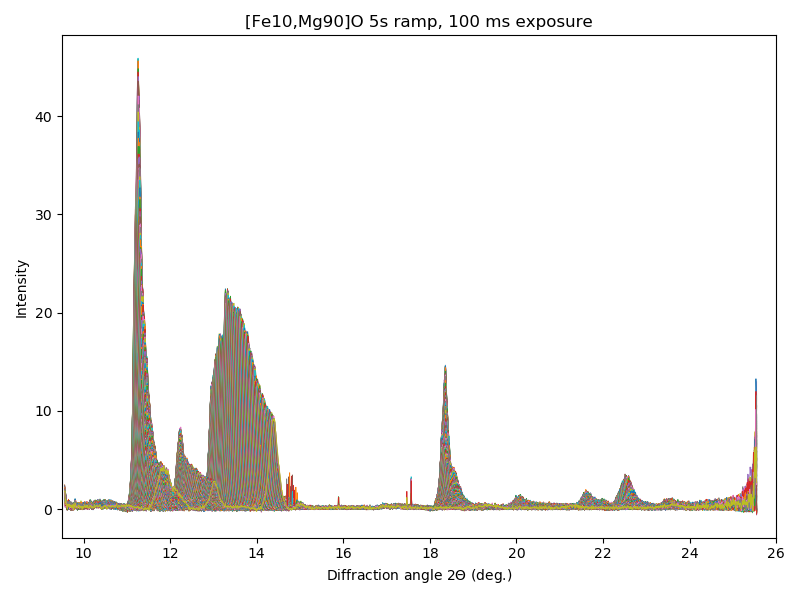

(4023,) 349 185


In [18]:
%cd -
# data for training
#plotting various plots to show development of bcc -> hcp transition
plt.figure()#figsize=(8,8)

plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

ax = plt.subplot(111)
N=len(theta[0])

X_1 = []# training: theta
X_2 = []# training: intensity
y   = []
global Ci,Ci_0,div_num,gap #indicates num of curves, and curves of class0.
div_num = 185 #indicates the boundary of spectral curves.
gap = 1 #20
Ci = 0  
Ci_0 = 0
X_axis=[] # used to store data for 3D plotting

for pct in range(0,total_XYfiles-1,gap):
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = 'limegreen' if pct <200 else 'blue')
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = color_sequence[Ci])
#     ax.plot(theta[pct], Icorrect[pct]+6-pct/50.,lw=1)
    ax.plot(theta[pct], Icorrect[pct],lw=0.6)
 
    #testX = torch.FloatTensor(theta[pct])
    #testX = torch.cat((testX),1)
    
    Icorrect_t = Icorrect[pct]
#     Icorrect_t = Icorrect[pct]+6-pct/50.
    theta_t = theta[pct]
    X_1.append(theta_t)
    X_2.append(Icorrect_t)
    X_axis.append(np.ones(N)*pct) 
    
    Ci += 1
    if pct <div_num:
        Ci_0 += 1
    #y.append(torch.zeros(1,size(theta[pct])) if pct < 200 else torch.ones(1,size(theta[pct]))

             
print(X_1[0].shape,Ci,Ci_0)


ax.set_ylabel('Intensity')
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')
# ax.set_ylim(-2,45)
ax.set_xlim(9.5,26)

plt.title('[Fe10,Mg90]O 5s ramp, 100 ms exposure') #, fontweight='bold'

# ax.spines['right'].set_visible(False) #remove right axis spine
# ax.spines['top'].set_visible(False) # remove top axis spine
plt.tight_layout()
plt.savefig(save_figures_to+"Original data used for training.png", bbox_inches='tight', dpi=300)

In [19]:
(np.size(X_1)), len(X_1), 349*4023

(1404027, 349, 1404027)

<IPython.core.display.Javascript object>


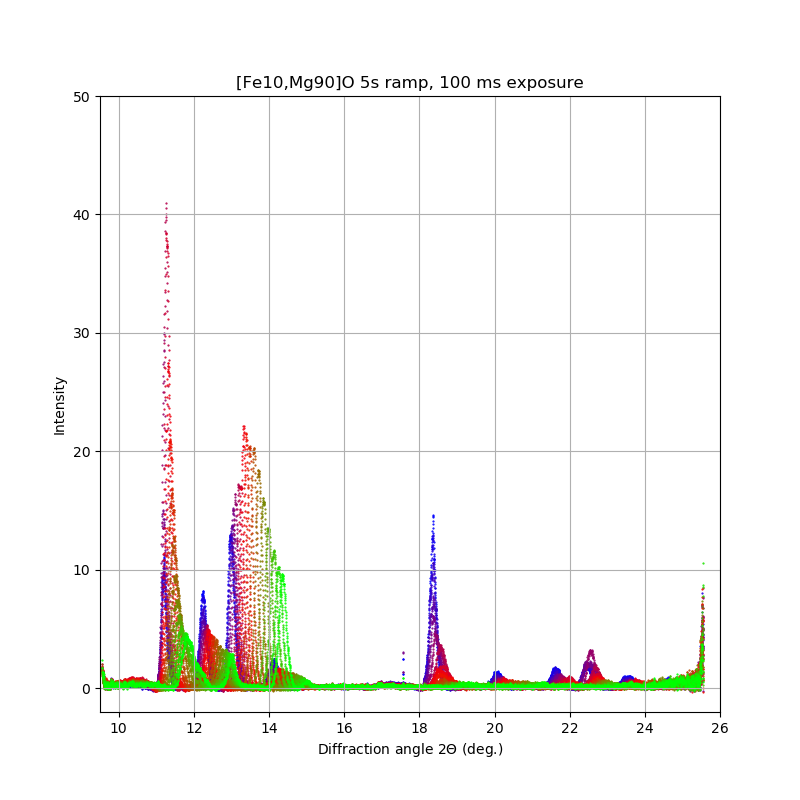

In [20]:
#plotting spectra in another way
plt.figure(figsize=(8,8))
plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16

ax = plt.subplot(111)
t_gap=20 # this parameter decide the number of spectral curves for test.

import matplotlib.cm as cm
colors = cm.brg(np.linspace(0, 1, len(range(0,total_XYfiles-1,t_gap)))) # or gist_rainbow

pos_d=0
for pct,cc in zip(range(0,total_XYfiles-1,t_gap),colors):
    pct = pct+pos_d
    plt.scatter(theta[pct], Icorrect[pct], color=cc,s=0.3)
    
ax.set_ylabel('Intensity') #, fontsize = 16,
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 16
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)
plt.grid(True)
plt.title('[Fe10,Mg90]O 5s ramp, 100 ms exposure') #, fontsize=16, fontweight='bold'
plt.savefig(save_figures_to+"Spectra data for testing (manually classified).png", bbox_inches='tight', dpi=600)

plt.tight_layout()


In [21]:
type(X_2)

list

In [22]:
standard_flag = 0
MinMaxNormlize_flag = 0
if standard_flag:
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_i = sc.fit_transform(X_2)
    # X = sc.fit(X_2)
    # X_train = sc.fit_transform(X_2)
    # X_test = sc.transform(X_test)
elif MinMaxNormlize_flag:
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler()
    X_i = sc.fit_transform(X_2)
else:
    X_i = X_2 - np.mean(X_2,axis=0)

<IPython.core.display.Javascript object>


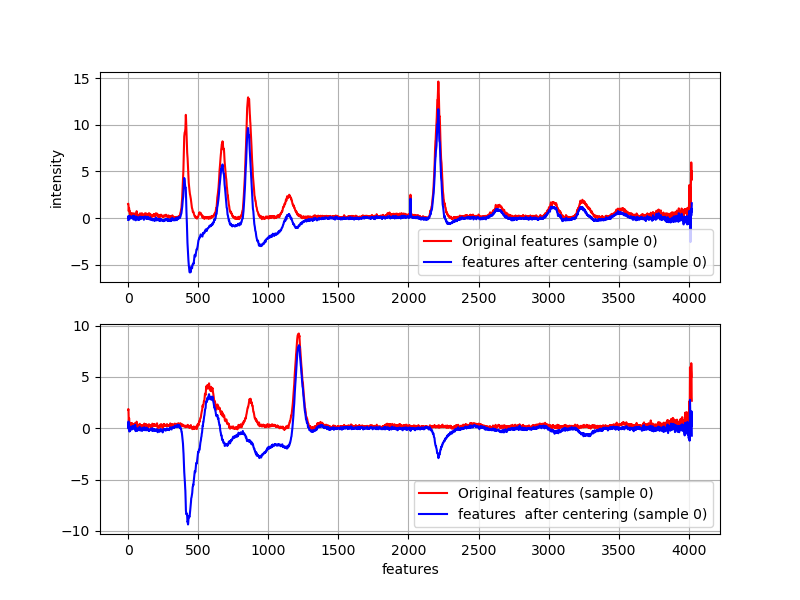

<IPython.core.display.Javascript object>


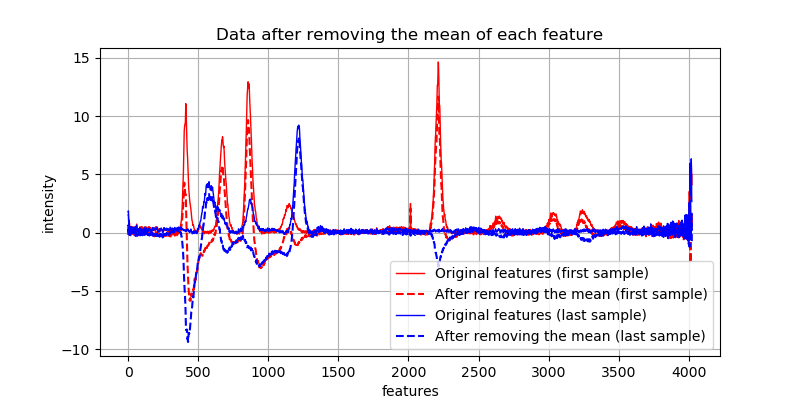

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=False, figsize=(8,6))

host1 = plt.subplot(211)
host2 = plt.subplot(212)

host1.plot(X_2[0],'r-',label='Original features (sample 0)')
host1.plot(X_i[0],'b-',label='features after centering (sample 0)')
# plt.title('Standardization of the dataset (sample 0)')
# host1.set_xlabel('features');
host1.set_ylabel('intensity');
host1.grid(True)
host1.legend()

host2.plot(X_2[-1],'r-',label='Original features (sample 0)')
host2.plot(X_i[-1],'b-',label='features  after centering (sample 0)')
# plt.title('Standardization of the dataset (sample 0)')
host2.set_xlabel('features');
host1.set_ylabel('intensity');
host2.grid(True)
host2.legend()


f1 = plt.figure(figsize=(8,4))
plt.plot(X_2[0],'r-',lw=1,label='Original features (first sample)')
plt.plot(X_i[0],'r--',label='After removing the mean (first sample)')
plt.plot(X_2[-1],'b-',lw=1,label='Original features (last sample)')
plt.plot(X_i[-1],'b--',label='After removing the mean (last sample)')
plt.title('Data after removing the mean of each feature')
plt.xlabel('features');
plt.ylabel('intensity');
plt.grid(True)
plt.legend()
f1.savefig(save_figures_to+"Removing the mean of each feature (first and last sample).svg")

In [24]:
print(X_i.mean(axis=0))
print(X_i.std(axis=0))

[ 4.19912433e-17  2.41767765e-17  3.10480708e-16 ...  1.67710481e-15
 -2.09828970e-15  3.90645809e-16]
[0.25872645 0.23615664 0.23176907 ... 1.77121769 1.77999433 2.89521417]


In [25]:
PCA_NUM_COMP = len(X_i)-1
print(PCA_NUM_COMP)

348


In [26]:
from sklearn.decomposition import PCA
Sum_Explained_variance =.99
pca = PCA(Sum_Explained_variance)
# pca = PCA(n_components=PCA_NUM_COMP)
X2_data =pca.fit_transform(X_i)
# X2_test = pca.transform(X_test)
N_Compents=pca.n_components_ 
print(X2_data.shape)
print(N_Compents)

(349, 13)
13


In [27]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.39425956 0.27637765 0.09818054 0.08041313 0.04614333 0.03288205
 0.02467175 0.01484469 0.00946923 0.00541763 0.00393546 0.00262299
 0.00198779]


<IPython.core.display.Javascript object>


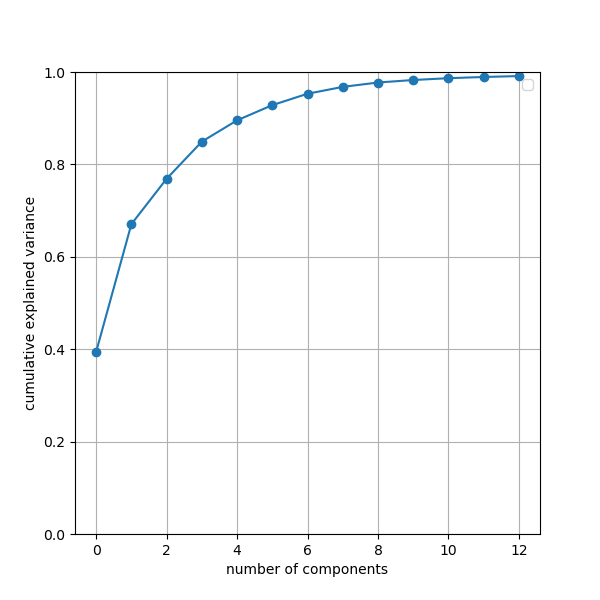

No handles with labels found to put in legend.


In [28]:
plt.figure(figsize=(6,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'o-')
plt.xlabel('number of components');
plt.grid(True)
plt.ylim(0,1.0)
plt.ylabel('cumulative explained variance');
plt.legend()


In [29]:
pca.components_.shape

(13, 4023)

The explained variance characteristics in PCA algorithm:

<IPython.core.display.Javascript object>


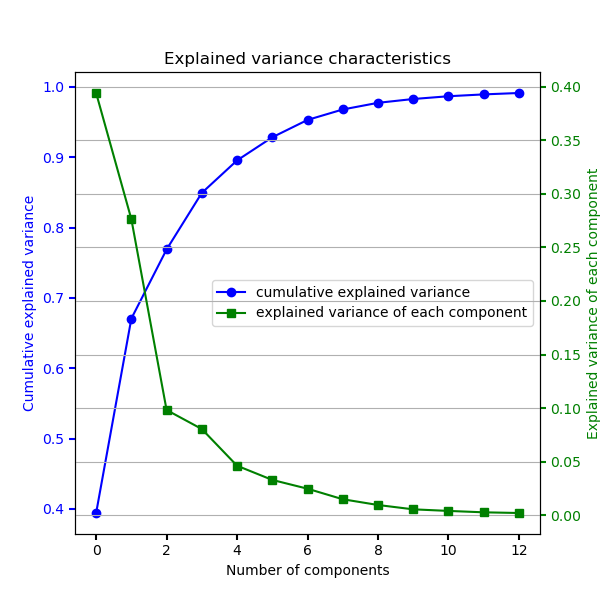

In [30]:
fig, host = plt.subplots(figsize=(6,6))
par1 = host.twinx()

p1, = host.plot(np.cumsum(pca.explained_variance_ratio_),'bo-',color='blue',label='cumulative explained variance')
p2, = par1.plot((pca.explained_variance_ratio_),'gs-',color='green',label='explained variance of each component')

host.set_xlabel("Number of components")
host.set_ylabel("Cumulative explained variance")
par1.set_ylabel("Explained variance of each component")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]

host.legend(lines, [l.get_label() for l in lines],loc='center right')#
plt.title('Explained variance characteristics')
plt.grid(True)

plt.savefig(save_figures_to+"Explained variance characteristics.svg")

<IPython.core.display.Javascript object>


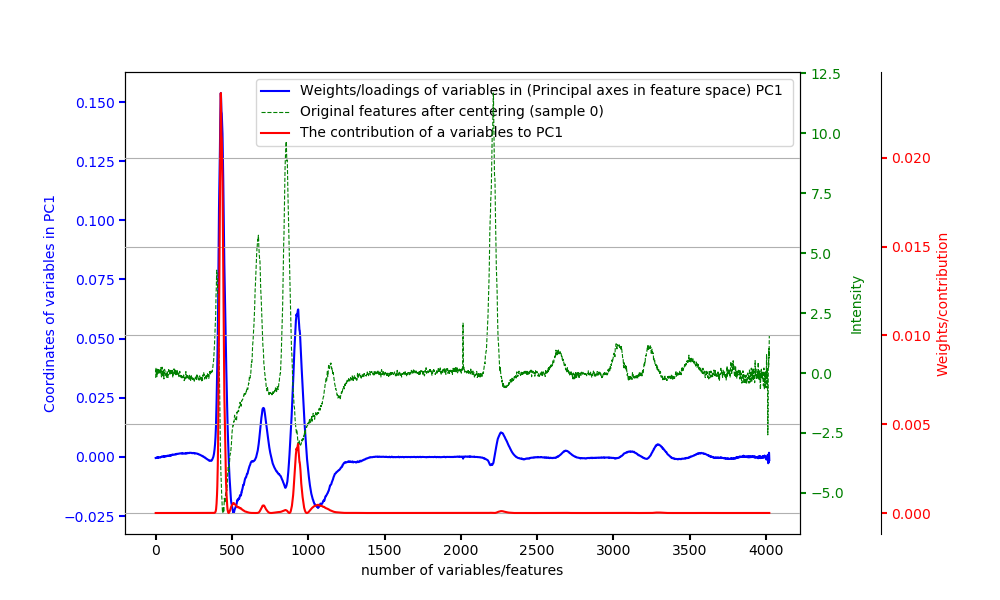

In [31]:

Contrib_PC1=(pca.components_[0,:]*pca.components_[0,:])

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots(figsize=(10,6))
fig.subplots_adjust(right=0.8)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.12))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot((pca.components_[0,:]),'b-',label='Weights/loadings of variables in (Principal axes in feature space) PC1 ')
p2, = par1.plot(X_i[0],'--',lw=0.8,color='green',label='Original features after centering (sample 0)')
p3, = par2.plot(Contrib_PC1, "r-", label='The contribution of a variables to PC1')


host.set_xlabel("number of variables/features")
host.set_ylabel("Coordinates of variables in PC1")
par1.set_ylabel("Intensity")
par2.set_ylabel("Weights/contribution")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines],loc='upper right')
plt.grid(True)
# plt.show()



<IPython.core.display.Javascript object>


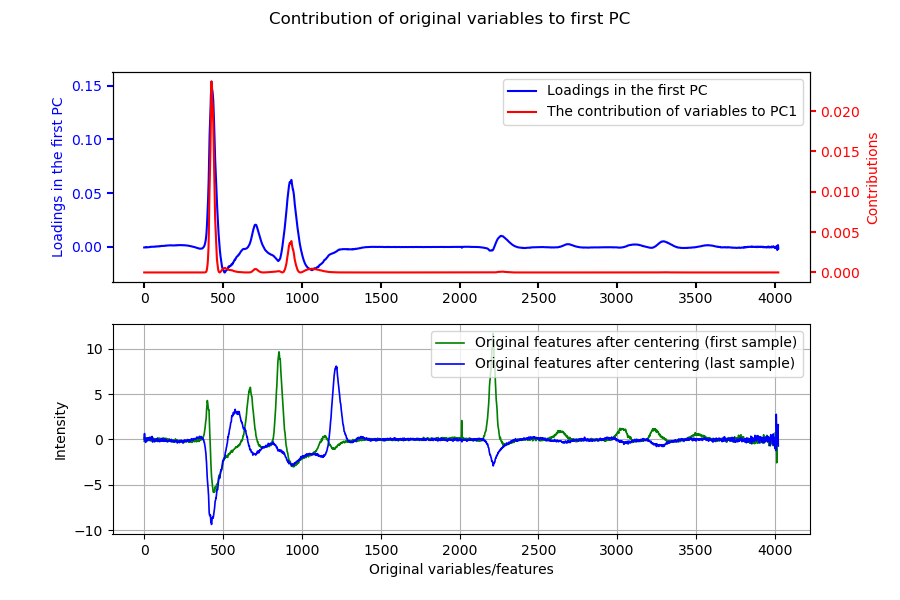

In [32]:
Contrib_PC1=(pca.components_[0,:]*pca.components_[0,:])

fig, ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(9,6))

host1 = plt.subplot(211)
par1 = host1.twinx()
host2 = plt.subplot(212)
# par2 = host2.twinx()

# share the secondary axes
host2.get_shared_y_axes().join(par1, par2)



p1, = host1.plot((pca.components_[0,:]),'b-',label='Loadings in the ﬁrst PC')
p2, = par1.plot(Contrib_PC1, "r-", label='The contribution of variables to PC1')

p2_1, = host2.plot(X_i[0],'g',lw=1.2,color='green',label='Original features after centering (first sample)')  #X_2  X_i
p2_2, = host2.plot(X_i[-1],'b',lw=1.2,label='Original features after centering (last sample)')  #X_2  X_i

host2.set_xlabel("Original variables/features")
host1.set_ylabel("Loadings in the ﬁrst PC")
par1.set_ylabel("Contributions")
host2.set_ylabel("Intensity")


host1.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host1.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host1.tick_params(axis='x', **tkw)

lines = [p1, p2]
host1.legend(lines, [l.get_label() for l in lines],loc='upper right')

lines2 = [p2_1, p2_2]
host2.legend(lines2, [l.get_label() for l in lines2],loc='upper right')
plt.suptitle('Contribution of original variables to first PC')
plt.grid(True)

plt.savefig(save_figures_to+"Contribution of original variables to first PC.svg")

loadings: (4023, 13) explained_variance_: (13,)
OveralWeights_var: (4023,)
Contribution_var: (4023,)


<IPython.core.display.Javascript object>


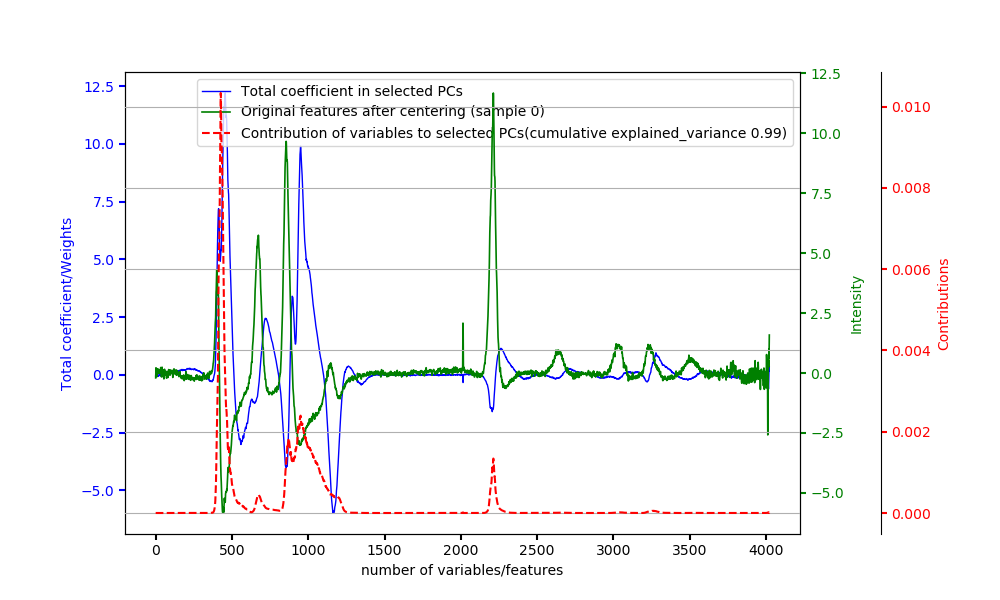

In [33]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
print('loadings:',loadings.shape,'explained_variance_:', pca.explained_variance_.shape)

OveralWeights_var=np.sum(loadings, axis=1)
Contribution_var=np.sum(np.absolute(loadings*loadings), axis=1)/np.sum(np.sum(np.absolute(loadings*loadings), axis=1))
print('OveralWeights_var:',OveralWeights_var.shape)
print('Contribution_var:',Contribution_var.shape)


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots(figsize=(10,6))
plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16
fig.subplots_adjust(right=0.8)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.12))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot((OveralWeights_var),'b',lw=1,label='Total coefficient in selected PCs')
p2, = par1.plot(X_i[0],'g',lw=1.2,color='green',label='Original features after centering (sample 0)')  #X_2  X_i
p3, = par2.plot((Contribution_var),'r--',lw=1.5,label='Contribution of variables to selected PCs(cumulative explained_variance %s)'%(Sum_Explained_variance))

host.set_xlabel("number of variables/features")
host.set_ylabel("Total coefficient/Weights")
par1.set_ylabel("Intensity")
par2.set_ylabel("Contributions")

# par1.set_ylim(-3, 5)
# par2.set_ylim(0.00022, 0.00027)

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines],loc='upper right')
plt.grid(True)
# plt.show()


loadings: (4023, 13) explained_variance_: (13,)
OveralWeights_var: (4023,)
Contribution_var: (4023,)


<IPython.core.display.Javascript object>


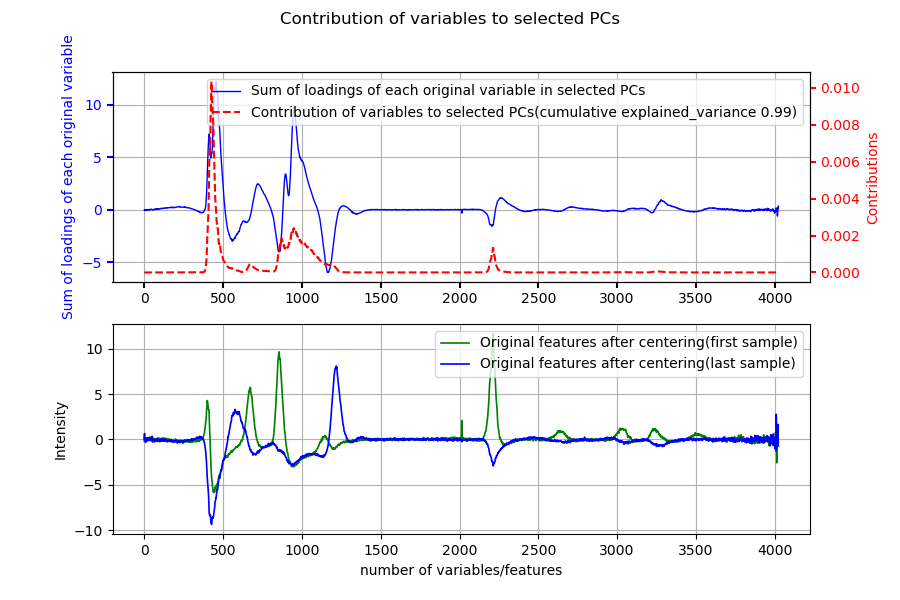

In [34]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
print('loadings:',loadings.shape,'explained_variance_:', pca.explained_variance_.shape)

OveralWeights_var=np.sum(loadings, axis=1)
Contribution_var=np.sum(np.absolute(loadings*loadings), axis=1)/np.sum(np.sum(np.absolute(loadings*loadings), axis=1))
print('OveralWeights_var:',OveralWeights_var.shape)
print('Contribution_var:',Contribution_var.shape)


fig, ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(9,6))

host1 = plt.subplot(211)
par1 = host1.twinx()
host2 = plt.subplot(212)
# par2 = host2.twinx()

# share the secondary axes
host2.get_shared_y_axes().join(par1, par2)



p1, = host1.plot((OveralWeights_var),'b',lw=1,label='Sum of loadings of each original variable in selected PCs')
p2, = par1.plot((Contribution_var),'r--',lw=1.5,label='Contribution of variables to selected PCs(cumulative explained_variance %s)'%(Sum_Explained_variance))

p2_1, = host2.plot(X_i[0],'g',lw=1.2,color='green',label='Original features after centering(first sample)')  #X_2  X_i
p2_2, = host2.plot(X_i[-1],'b',lw=1.2,label='Original features after centering(last sample)')  #X_2  X_i

host2.set_xlabel("number of variables/features")
host1.set_ylabel("Sum of loadings of each original variable")
par1.set_ylabel("Contributions")
host2.set_ylabel("Intensity")


host1.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host1.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host1.tick_params(axis='x', **tkw)

lines = [p1, p2]
host1.legend(lines, [l.get_label() for l in lines],loc='upper right')

lines2 = [p2_1, p2_2]
host2.legend(lines2, [l.get_label() for l in lines2],loc='upper right')
plt.suptitle('Contribution of variables to selected PCs')
host1.grid(True)
host2.grid(True)
plt.savefig(save_figures_to+"Contribution of variables to selected PCs.svg")

<IPython.core.display.Javascript object>


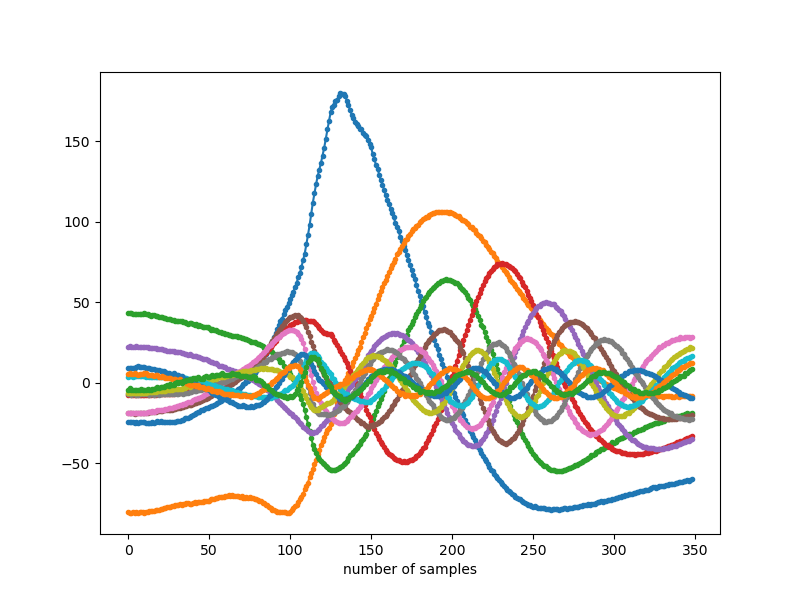

Projected by PCA: (349, 13)


<IPython.core.display.Javascript object>


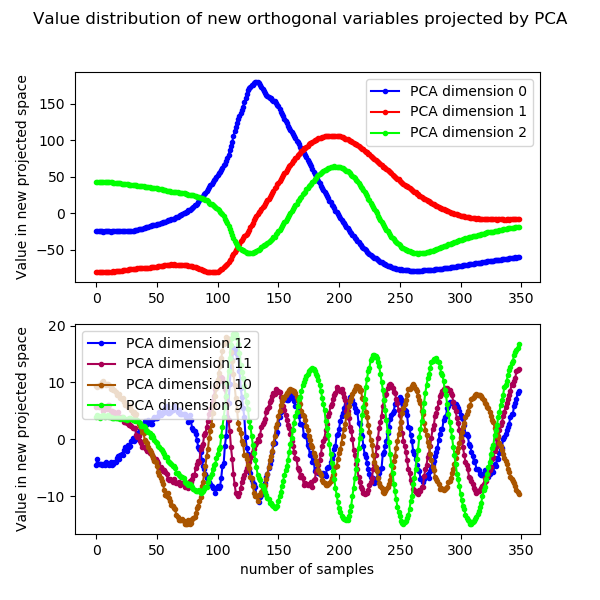

<IPython.core.display.Javascript object>


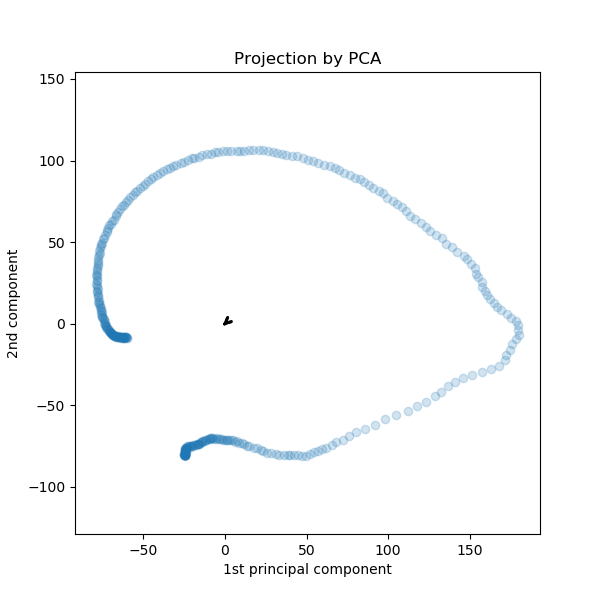

(349,) PCA_components: [[-4.48752215e-04 -4.13995549e-04 -4.10067014e-04 ...  1.76862094e-03
   6.54804780e-04 -1.33092762e-03]
 [-7.02734451e-04 -6.27188427e-04 -6.21592454e-04 ... -2.74226658e-06
  -1.79467225e-04 -7.19951585e-04]
 [-3.52982509e-04 -7.75144894e-05  3.07745798e-05 ... -1.46771065e-03
   1.18697726e-04 -2.32610762e-04]
 ...
 [-7.64639877e-04 -1.62015830e-03 -8.55486214e-04 ... -7.86034769e-03
  -8.37427426e-03 -2.72936810e-02]
 [-9.94532658e-04  9.76176656e-04  2.01249420e-03 ...  1.93153516e-02
   1.67879009e-02  1.50964250e-02]
 [ 1.25589181e-03 -6.53408650e-05  9.95479426e-04 ...  4.14439874e-02
   3.57108463e-02  3.86031695e-02]] (13, 4023)


<IPython.core.display.Javascript object>


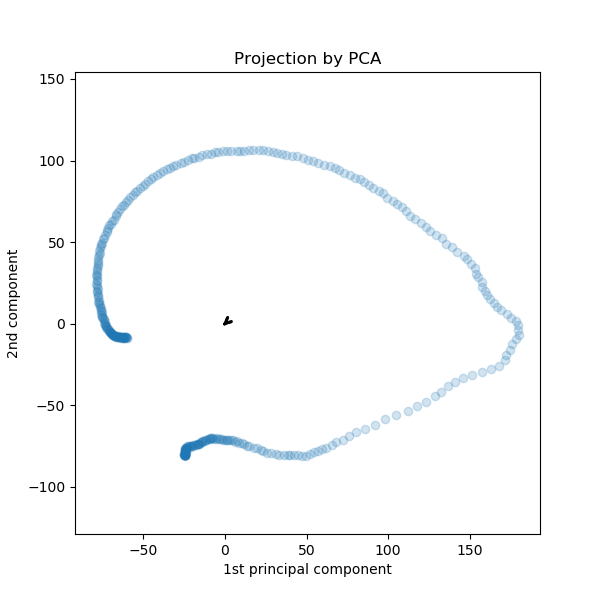

(349,) PCA_components: [[-4.48752215e-04 -4.13995549e-04 -4.10067014e-04 ...  1.76862094e-03
   6.54804780e-04 -1.33092762e-03]
 [-7.02734451e-04 -6.27188427e-04 -6.21592454e-04 ... -2.74226658e-06
  -1.79467225e-04 -7.19951585e-04]
 [-3.52982509e-04 -7.75144894e-05  3.07745798e-05 ... -1.46771065e-03
   1.18697726e-04 -2.32610762e-04]
 ...
 [-7.64639877e-04 -1.62015830e-03 -8.55486214e-04 ... -7.86034769e-03
  -8.37427426e-03 -2.72936810e-02]
 [-9.94532658e-04  9.76176656e-04  2.01249420e-03 ...  1.93153516e-02
   1.67879009e-02  1.50964250e-02]
 [ 1.25589181e-03 -6.53408650e-05  9.95479426e-04 ...  4.14439874e-02
   3.57108463e-02  3.86031695e-02]] (13, 4023)
Sum_Explained_variance_TEST: 0.6
(349, 2)
2
X_new projected back(PCA Explained_variance =0.95): (349, 4023)
X_new projected back(PCA Explained_variance =0.45): (349, 4023)


<IPython.core.display.Javascript object>


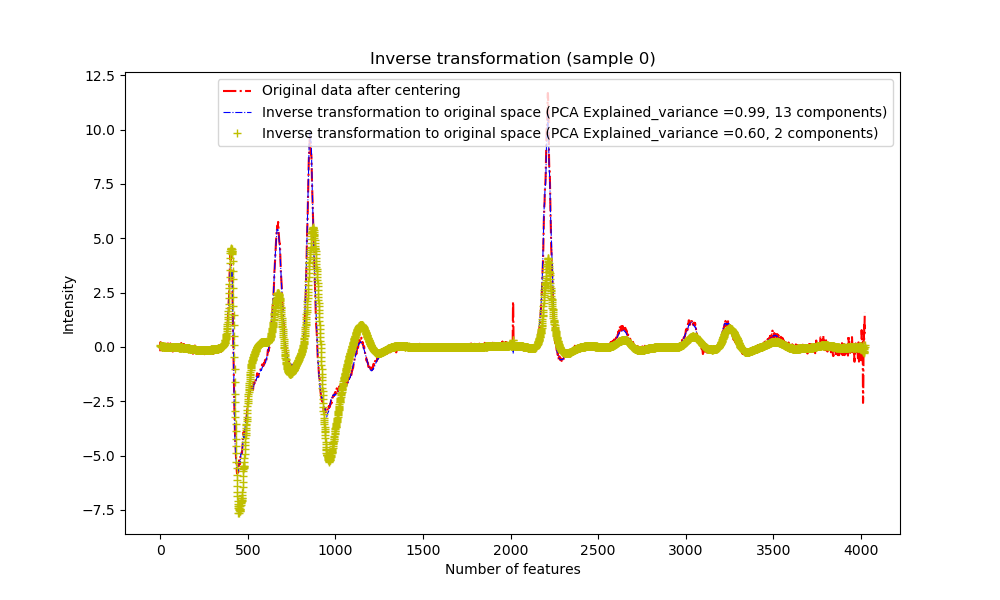

<IPython.core.display.Javascript object>


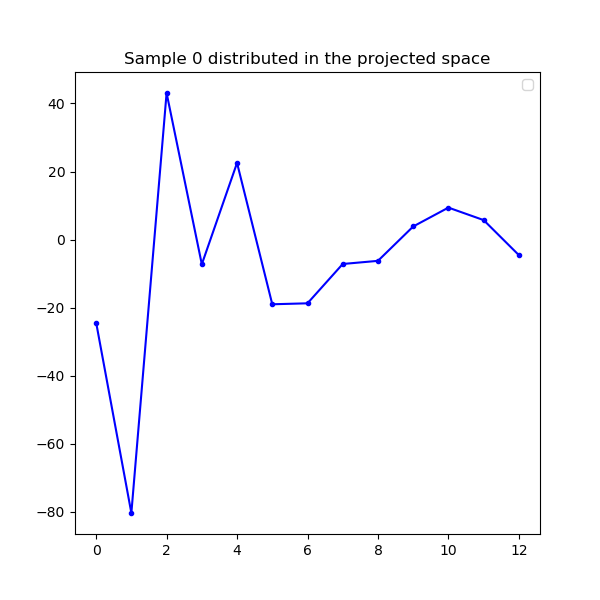

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


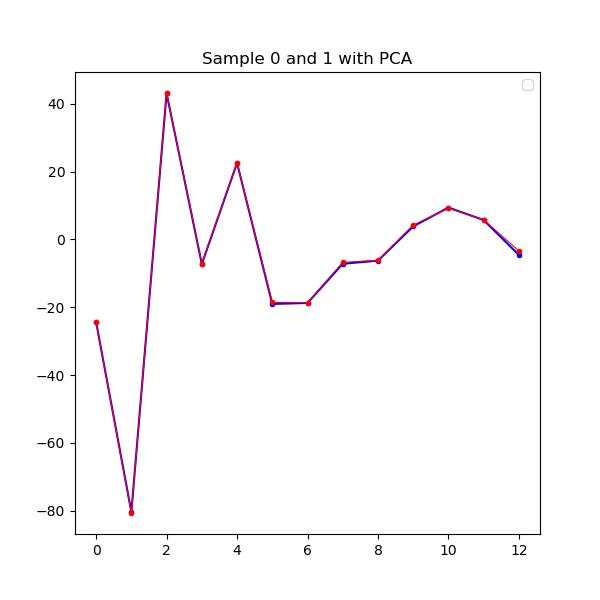

No handles with labels found to put in legend.


(2, 13)


<IPython.core.display.Javascript object>


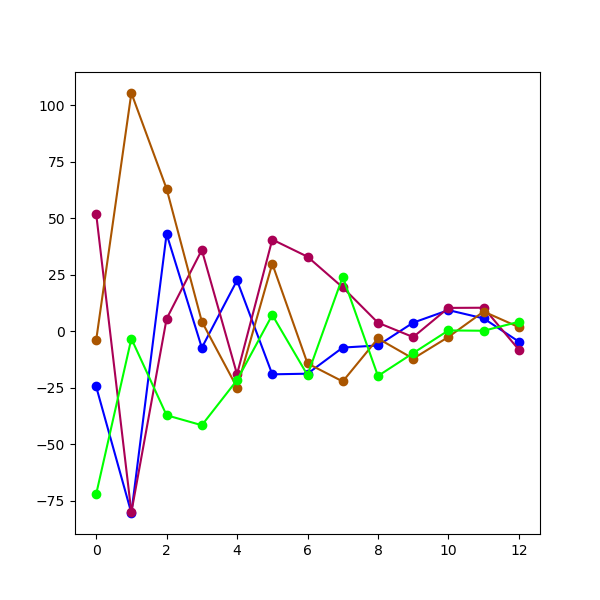

In [35]:
plt.figure(figsize=(8,6))
plt.plot(X2_data,'.-')
plt.xlabel('number of samples');
print('Projected by PCA:',X2_data.shape)

comp_n = 3
import matplotlib.cm as cm
colors = cm.brg(np.linspace(0, 1, len(range(0,comp_n,1)))) # or gist_rainbow
# colors = ['red','blue','yellow']

##### plot samples distribution in the some components/dimension
fig, ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(6,6))
plt.subplot(2,1,1)
i=0
j=1
for cc in colors:
    if i <3:
        plt.plot(X2_data[:,i],'.-',color=cc,label='PCA dimension %i' %i)
        i=i+1
#     else:
#         plt.plot(X2_data[:,-j],'.-',color=cc,label='PCA dimension %i' %(N_Compents-j))
#         j=j+1
plt.legend()
plt.ylabel('Value in new projected space');
plt.subplot(2,1,2)
colors = cm.brg(np.linspace(0, 1, 4)) # or gist_rainbow
j=1
for cc in colors:
    plt.plot(X2_data[:,-j],'.-',color=cc,label='PCA dimension %i' %(N_Compents-j))
    j=j+1
# plt.plot(X2_data[:,100],'.-',color='red',label='PCA dimension 100')    
plt.legend()
plt.xlabel('number of samples');
plt.ylabel('Value in new projected space');
plt.suptitle("Value distribution of new orthogonal variables projected by PCA")
plt.savefig(save_figures_to+"Value distribution of new orthogonal variables projected by PCA.svg")
# plt.title("Samples distributed in the first %i components/dimension" %comp_n)   


###### first two components ###############
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.figure(figsize=(6,6))
print(X2_data[:, 0].shape,'PCA_components:',pca.components_,pca.components_.shape)
plt.scatter(X2_data[:, 0], X2_data[:, 1], alpha=0.2)
i_comp = 0
for length, vector in zip(pca.explained_variance_[0:2], pca.components_[:,0:2]):
    v = vector[0:2] * 30 * np.sqrt(length)
    draw_vector(pca.mean_[0:2], pca.mean_[0:2] + v)
    i_comp = i_comp +1
plt.axis('equal');
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")


# plot data
plt.figure(figsize=(6,6))
print(X2_data[:, 0].shape,'PCA_components:',pca.components_,pca.components_.shape)
plt.scatter(X2_data[:, 0], X2_data[:, 1], alpha=0.2)
i_comp = 0
for length, vector in zip(pca.explained_variance_[0:2], pca.components_[:,0:2]):
    v = vector[0:2] * 30 * np.sqrt(length)
    draw_vector(pca.mean_[0:2], pca.mean_[0:2] + v)
    i_comp = i_comp +1
plt.axis('equal');
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

###### projected back to original space##################
X_new = pca.inverse_transform(X2_data)
Sum_Explained_variance_TEST =0.6
pca_TEST = PCA(Sum_Explained_variance_TEST)
X_i_TEST=X_i
X2_data_TEST =pca_TEST.fit_transform(X_i_TEST)
print('Sum_Explained_variance_TEST:',Sum_Explained_variance_TEST)
# X2_test = pca.transform(X_test)
N_Compents_TEST=pca_TEST.n_components_ 
print(X2_data_TEST.shape)
print(N_Compents_TEST)

X_new_TEST = pca_TEST.inverse_transform(X2_data_TEST)
print('X_new projected back(PCA Explained_variance =0.95):', X_new_TEST.shape)
print('X_new projected back(PCA Explained_variance =0.45):', X_new.shape)
fig, ax = plt.subplots(1, 1,figsize=(10,6))
for pct in range(0,1):
    ax.plot(X_i[pct, :],'r-.',lw=1.5,label='Original data after centering')
    # plt.figure(figsize=(6,6))
    ax.plot(X_new[pct, :],'b-.',lw=0.8,label='Inverse transformation to original space (PCA Explained_variance =%.2f, %s components)'%(Sum_Explained_variance, N_Compents))
    ax.plot(X_new_TEST[pct, :],'y+',lw=1.5,label='Inverse transformation to original space (PCA Explained_variance =%.2f, %s components)'%(Sum_Explained_variance_TEST, N_Compents_TEST))
#     ax.plot(X_new_TEST[pct, :],'y+',lw=1.5,label='Inverse transformation to original space (PCA Explained_variance =%.2f, %s components)'%(Sum_Explained_variance_test, N_Compents_TEST))
ax.legend()
plt.title("Inverse transformation (sample 0)")
ax.set_ylabel('Intensity') #, fontsize = 16,
ax.set_xlabel('Number of features') # Diffraction angle 2$\Theta$ (deg.), fontsize = 16
plt.savefig(save_figures_to+"Inverse transformation (sample 0).svg")

plt.figure(figsize=(6,6))
plt.plot(X2_data[0,:],'.-b')
plt.title("Sample 0 distributed in the projected space")
plt.legend()

plt.figure(figsize=(6,6))
print(X2_data[-3:-1].shape)
plt.plot(X2_data[0,:],'.-b')
plt.plot(X2_data[1,:],'.-r',lw=0.8)
plt.title("Sample 0 and 1 with PCA")
plt.legend()


t_gap=100 
import matplotlib.cm as cm
colors = cm.brg(np.linspace(0, 1, len(range(0,total_XYfiles-1,t_gap)))) # or gist_rainbow

plt.figure(figsize=(6,6))
for pct,cc in zip(range(0,total_XYfiles-1,t_gap),colors):
    plt.plot(X2_data[pct],'-o',color=cc)

In [36]:
from sklearn.cluster import SpectralClustering
from time import time
t0= time()
Kluster = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
y_pred = Kluster.fit_predict(X2_data)
t1= time()
print("training done in %0.3fs" % (t1 - t0))
print(Kluster)
print(y_pred)

# y_pred_train = Kluster.labels_

training done in 0.079s
SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
                   coef0=1, degree=3, eigen_solver=None, eigen_tol=0.0,
                   gamma=1.0, kernel_params=None, n_clusters=2, n_init=10,
                   n_jobs=None, n_neighbors=10, random_state=None)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

In [37]:
Kluster.get_params()

{'affinity': 'nearest_neighbors',
 'assign_labels': 'kmeans',
 'coef0': 1,
 'degree': 3,
 'eigen_solver': None,
 'eigen_tol': 0.0,
 'gamma': 1.0,
 'kernel_params': None,
 'n_clusters': 2,
 'n_init': 10,
 'n_jobs': None,
 'n_neighbors': 10,
 'random_state': None}

In [38]:
Kluster.affinity_matrix_

<349x349 sparse matrix of type '<class 'numpy.float64'>'
	with 3783 stored elements in Compressed Sparse Row format>

In [39]:
FinlPredLabel =  y_pred if y_pred[0]==0 else 1-y_pred

In [40]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [41]:
torch.cuda.device_count()

1

In [42]:
global D_len
D_len=N_Compents
X_1 = torch.empty((0,D_len))
print(X_1, type(X_1))
# plt.figure(figsize=(6,6))
gap =1
for pct in range(0,total_XYfiles-1,gap):
#     ax.plot(X2_data[pct,:],lw=0.6)
    X_1_temp = torch.arange(1, D_len+1).reshape(1,-1)
    X_1= torch.cat((X_1,X_1_temp),0)
print(X_1.shape,type(X_1),X_1)

tensor([], size=(0, 13)) <class 'torch.Tensor'>
torch.Size([349, 13]) <class 'torch.Tensor'> tensor([[ 1.,  2.,  3.,  ..., 11., 12., 13.],
        [ 1.,  2.,  3.,  ..., 11., 12., 13.],
        [ 1.,  2.,  3.,  ..., 11., 12., 13.],
        ...,
        [ 1.,  2.,  3.,  ..., 11., 12., 13.],
        [ 1.,  2.,  3.,  ..., 11., 12., 13.],
        [ 1.,  2.,  3.,  ..., 11., 12., 13.]])


In [43]:
type(X2_data)

numpy.ndarray

# Curve-wise ambigious region 

In [44]:
    var_C0=0 # initial value of class 0;
    Ntn = len(X_1)
    for j in range(Ntn-1): # test data sets(curves)    
        if (FinlPredLabel[j] == 0) and (FinlPredLabel[(j+1)]==0):
            var_C0 = j+1
        else:
            break  
    var_C1=Ntn-1 # initial value of class 1; So after iteration, if var_C1=Ntn-1(still this value), it means the following conditions are not met.
    for j in range(Ntn-1,0,-1): # test data sets(curves)   
        if (FinlPredLabel[j] == 1) and (FinlPredLabel[(j-1)]==1):
            var_C1 = j-1
        else:
            break
    torch.set_printoptions(threshold=10_000)
    np.set_printoptions(threshold=10_000)
     
    if var_C0==Ntn-1:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 0.")
    elif var_C1==0:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found and all curves are labeled as 1.")
    elif var_C0==0 and var_C1==Ntn-1:
        Glo_acc = 0.00
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 1." )
    else:
        Glo_acc = 1-float((var_C1-var_C0-1)/Ntn)
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("Overall classification accuracy is %.3f" % (Glo_acc*100)+"%")
    

Interval with low classification confidence is (175 ,  176)
Overall classification accuracy is 100.000%


# Curves near the boundary

<IPython.core.display.Javascript object>


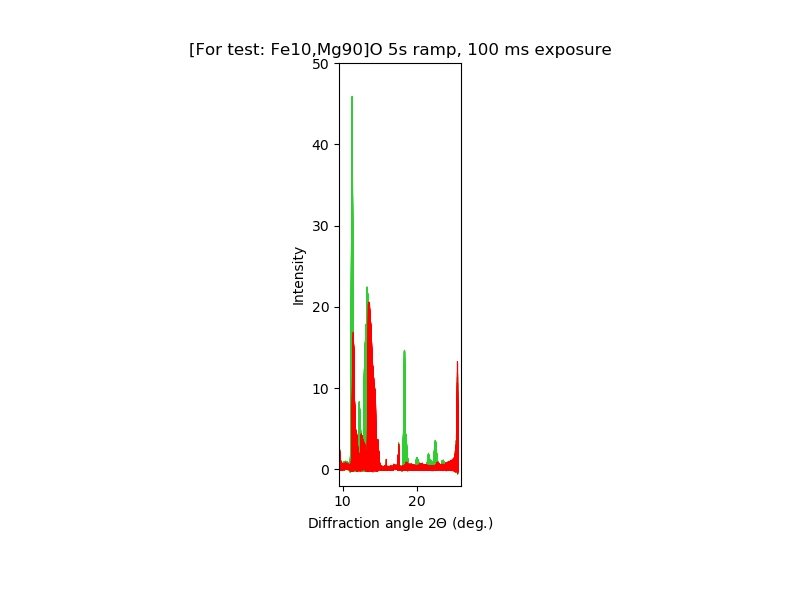

0 [] 349 <class 'list'> <class 'list'>
349 185


In [45]:
## plotting various plots to show development of bcc -> hcp transition
plt.figure(figsize=(8,6))

plt.rc('xtick') #,labelsize=16
plt.rc('ytick') #,labelsize=16

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

ax = plt.subplot(111)

Xt_1 = []# theta for test
Xt_2 = []# intensity for test
yt   = []
global Ntn,Ntn_0 #indicates num of test curves, and curves of class0.
Ntn = 0  # num of test curves,
Ntn_0 = 0 #and num of curves of class0
pos_d=0
t_gap=1
for pct in range(0,total_XYfiles-1,t_gap):
    pct = pct+pos_d
    ax.plot(theta[pct], Icorrect[pct], color = 'limegreen' if pct <200 else 'red',lw=0.8)
#     ax.plot(theta[pct], Icorrect[pct],lw=0.8)
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = color_sequence[Ci])
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50.)
    Ntn += 1
    if pct <div_num:
        Ntn_0 += 1
#         yt.append(np.zeros(theta[0].size)) # tensor type
#     else:
#         yt.append(np.ones(theta[0].size))
    

    Icorrect_t = Icorrect[pct]
    theta_t = theta[pct]
    Xt_1.append(theta_t)
    Xt_2.append(Icorrect_t)
    #y.append(torch.zeros(1,size(theta[pct])) if pct < 200 else torch.ones(1,size(theta[pct]))

print(len(yt),yt,len(Xt_1),type(Xt_1),type(yt))            


ax.set_ylabel('Intensity')#, fontsize = 16,
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)')#, fontsize = 16
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)

plt.title('[For test: Fe10,Mg90]O 5s ramp, 100 ms exposure')
plt.savefig(save_figures_to+"Spectra data for testing (manually classified).png", bbox_inches='tight', dpi=300)

# ax.spines['right'].set_visible(False) #remove right axis spine
# ax.spines['top'].set_visible(False) # remove top axis spine
plt.tight_layout()
print(Ntn,Ntn_0)

<class 'list'>


<IPython.core.display.Javascript object>


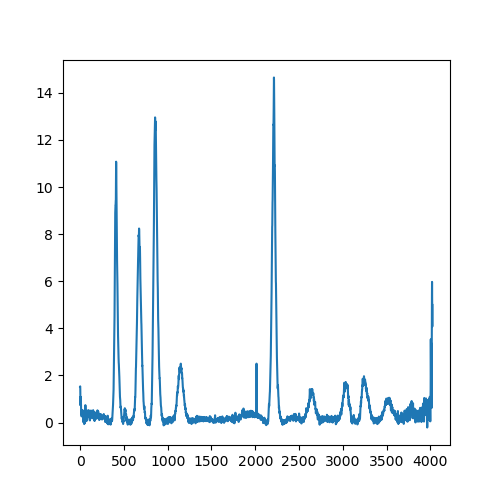

torch.Size([349, 4023]) <class 'torch.Tensor'> <class 'list'>


In [46]:
# data for testing
N = len(Xt_1[0])

global Xt,yt
print(type(Xt_1))
Xt_1=torch.FloatTensor(Xt_1) # convert list type to tensor
Xt_2=torch.FloatTensor(Xt_2) # convert list type to tensor
Xt_1=torch.reshape(Xt_1,(-1,N))
Xt_2=torch.reshape(Xt_2,(-1,N))

Xt_1plt=torch.reshape(Xt_1,(-1,1))
Xt_2plt=torch.reshape(Xt_2,(-1,1))
Xt=torch.cat((Xt_1plt,Xt_2plt),1).to(device)

X2t=Xt_2.to(device) # only use intensity information
plt.figure(figsize=(5,5))
plt.plot(Xt_2[0,:])

# yt_1 = torch.zeros(Ntn_0 * (theta[0].size), dtype=torch.long)
# yt_2 = torch.ones((Ntn-Ntn_0)* (theta[0].size), dtype=torch.long)
# yt   = torch.cat((yt_1,yt_2),0).to(device)
# print(Xt_1.shape,Xt_2.shape,Ntn,Ntn_0,Xt.shape,yt.shape,yt,Xt_1,Xt_2,sep='\n')
print(X2t.shape,type(Xt_1),type(yt))



# yue_plot_data(Xt, yt, axl,axr,byl,byh)

In [47]:
if var_C0==Ntn-1:
    p_start0 = 0 # start curve
    p_end0   = Ntn # end curv   
elif var_C1==0:
    p_start0 = 0 # start curve
    p_end0   = Ntn # end curv  
else:
    p_start0 = var_C0-5 if var_C0>5 else  var_C0 # start curve
    p_end0   = var_C1+5  if var_C1+5<=Ntn else Ntn


# p_start = p0_num*gap
# p_end = p_num*gap
print(p_start0,p_end0)

170 181


In [48]:
##### =================calculate the label for the whole curve ========================================================
#======================================================================================================================
FinlPredLabel = torch.LongTensor(FinlPredLabel)
# FinlPredLabel = torch.FloatTensor(FinlPredLabel)

Ct_prid=torch.zeros(N*Ntn, dtype=torch.long).to(device) # predicted test spectra label.
print('class type:',type(Ct_prid))
for j in range(Ntn): # test data sets(number of curves)    
    classId=FinlPredLabel[j]
    
    for k in range(N):
        Ct_prid[k+j*N]=classId
print(Ct_prid.shape,Xt.shape)

class type: <class 'torch.Tensor'>
torch.Size([1404027]) torch.Size([1404027, 2])


In [49]:
D_len=N
# different type of labels:
PCt_prid0 = Ct_prid[p_start0*D_len:p_end0*D_len] # Final predict label with model and weights
# PZt0      = Zt[p_start0*D_len:p_end0*D_len] # label directly predicted by the model
# values of x-axis and y-axis
PXt0      = torch.zeros((p_end0-p_start0)*D_len,2)

Xt_temp   = Xt[p_start0*D_len:p_end0*D_len,:]
print(PXt0.shape,Xt.shape)

n=0
for j in range(p_start0,p_end0):    
#     PXt0[(j-p_start0)*D_len:(j+1-p_start0)*D_len,1] = Xt[j*D_len:(j+1)*D_len,1]+6-j/1.
    PXt0[n*D_len:(n+1)*D_len,1] = Xt_temp[n*D_len:(n+1)*D_len,1]-j/1.
    PXt0[n*D_len:(n+1)*D_len,0] = Xt_temp[n*D_len:(n+1)*D_len,0]
    n=n+1
    
print(PXt0.shape,Xt.shape,PXt0,Xt)

torch.Size([44253, 2]) torch.Size([1404027, 2])
torch.Size([44253, 2]) torch.Size([1404027, 2]) tensor([[   9.5604, -167.9704],
        [   9.5644, -168.2130],
        [   9.5683, -168.7000],
        ...,
        [  25.5417, -179.3076],
        [  25.5456, -180.2735],
        [  25.5496, -178.3448]]) tensor([[ 9.5604,  1.5272],
        [ 9.5644,  1.5370],
        [ 9.5683,  1.4122],
        ...,
        [25.5417,  5.3101],
        [25.5456,  3.0696],
        [25.5496,  2.6791]], device='cuda:0')


<IPython.core.display.Javascript object>


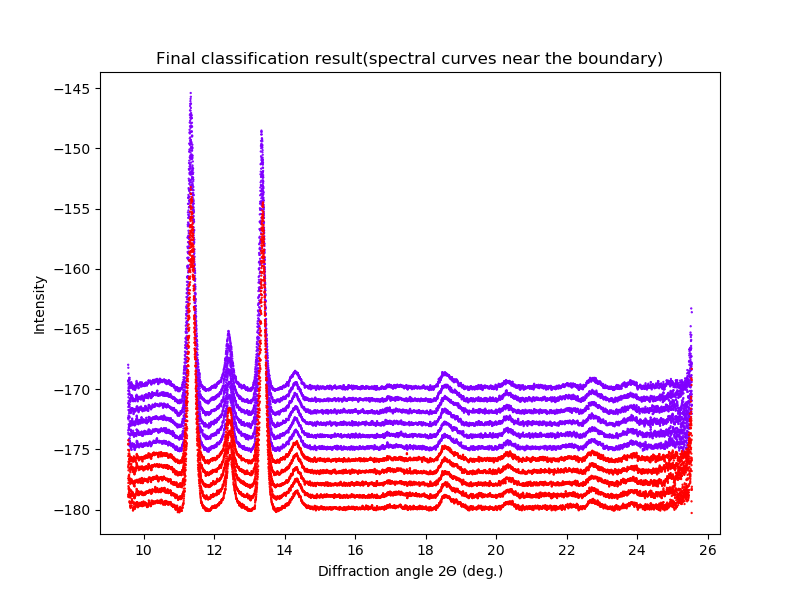

In [50]:
plt.figure(figsize=(8,6))
# yue_plot_data(PXt0, PCt_prid0, axl,axr,Pbyl,Pbyh)
plot_data(PXt0, PCt_prid0)
plt.title('Final classification result(spectral curves near the boundary)')
plt.savefig(save_figures_to+"Final classification result(spectral curves near the boundary).png", bbox_inches='tight', dpi=300)


In [51]:
def ConfidenceAcc(FinlPredLabel):  
    var_C0=0 # initial value of class 0;
    Ntn = total_XYfiles-1
    for j in range(Ntn-1): # test data sets(curves)    
        if (FinlPredLabel[j] == 0) and (FinlPredLabel[(j+1)]==0):
            var_C0 = j+1
        else:
            break  
    var_C1=Ntn-1 # initial value of class 1; So after iteration, if var_C1=Ntn-1(still this value), it means the following conditions are not met.
    for j in range(Ntn-1,0,-1): # test data sets(curves)   
        if (FinlPredLabel[j] == 1) and (FinlPredLabel[(j-1)]==1):
            var_C1 = j-1
        else:
            break
    torch.set_printoptions(threshold=10_000)
    np.set_printoptions(threshold=10_000)
     
    if var_C0==Ntn-1:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 0.")
    elif var_C1==0:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found and all curves are labeled as 1.")
    elif var_C0==0 and var_C1==Ntn-1:
        Glo_acc = 0.00
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 1." )
    else:
        Glo_acc = 1-float((var_C1-var_C0-1)/Ntn)
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("Overall classification accuracy is %.3f" % (Glo_acc*100)+"%")
    return Glo_acc*100, var_C0
Glo_acc , Amb_0= ConfidenceAcc(FinlPredLabel)
print(Glo_acc, Amb_0)

Interval with low classification confidence is (175 ,  176)
Overall classification accuracy is 100.000%
100.0 175


In [52]:
# Explained_variance = np.concatenate((np.arange(0.55,0.999,0.01).reshape((1, -1)), np.arange(0.999,0.9999,0.0001).reshape((1, -1))), axis=1)
Explained_variance = np.concatenate((np.arange(0.55,0.999,0.01), np.arange(0.999,0.9999,0.0001)))
Explained_variance

array([0.55  , 0.56  , 0.57  , 0.58  , 0.59  , 0.6   , 0.61  , 0.62  ,
       0.63  , 0.64  , 0.65  , 0.66  , 0.67  , 0.68  , 0.69  , 0.7   ,
       0.71  , 0.72  , 0.73  , 0.74  , 0.75  , 0.76  , 0.77  , 0.78  ,
       0.79  , 0.8   , 0.81  , 0.82  , 0.83  , 0.84  , 0.85  , 0.86  ,
       0.87  , 0.88  , 0.89  , 0.9   , 0.91  , 0.92  , 0.93  , 0.94  ,
       0.95  , 0.96  , 0.97  , 0.98  , 0.99  , 0.999 , 0.9991, 0.9992,
       0.9993, 0.9994, 0.9995, 0.9996, 0.9997, 0.9998, 0.9999])

Explained_variance 0.550:
Number of PCs 2:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Interval with low classification confidence is (173 ,  174)
Overall classification accuracy is 100.000%
Explained_variance 0.570:
Number of PCs 2:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1

Explained_variance 0.750:
Number of PCs 3:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Interval with low classification confidence is (171 ,  172)
Overall classification accuracy is 100.000%
Explained_variance 0.770:
Number of PCs 4:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1

Explained_variance 0.950:
Number of PCs 7:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Interval with low classification confidence is (175 ,  176)
Overall classification accuracy is 100.000%
Explained_variance 0.970:
Number of PCs 9:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1

Explained_variance 0.999:
Number of PCs 162:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Interval with low classification confidence is (178 ,  179)
Overall classification accuracy is 100.000%
Explained_variance 0.999:
Number of PCs 170:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1

Explained_variance 1.000:
Number of PCs 283:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Interval with low classification confidence is (178 ,  179)
Overall classification accuracy is 100.000%
Explained_variance 1.000:
Number of PCs 301:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0

<IPython.core.display.Javascript object>


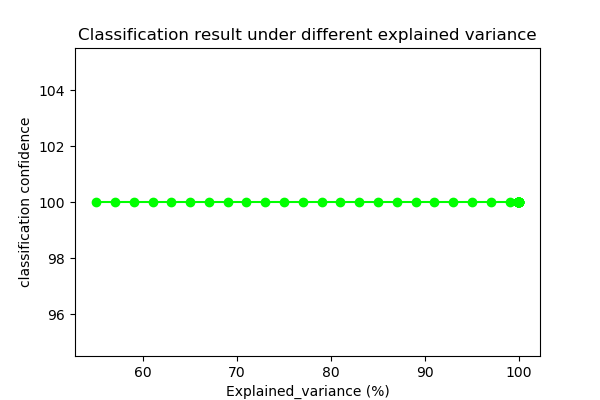

<IPython.core.display.Javascript object>


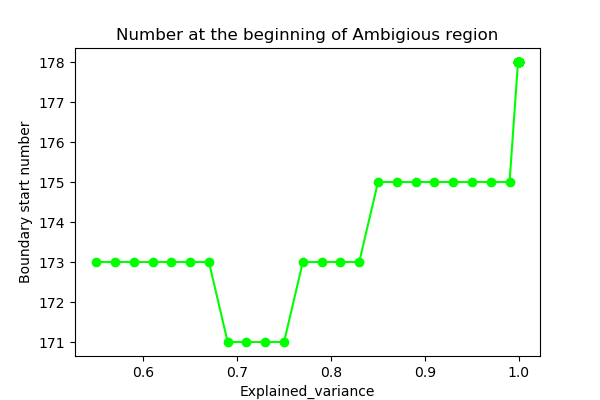

<IPython.core.display.Javascript object>


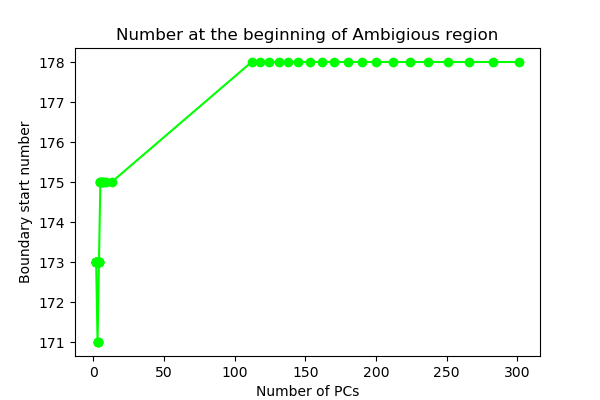

Text(0, 0.5, 'Boundary start number')

In [53]:
# Explained_variance = np.arange(0.55,0.9995,0.02) #[0.6, 0.75, 0.9, 0.95, 0.98]
Explained_variance = np.concatenate((np.arange(0.55,0.999,0.02), np.arange(0.999,0.9999,0.00005)))

X2_data ,N_Compents, Glo_acc, Amb_0= list(),list(),list(),list()
for i in range(0,len(Explained_variance)):
    Explained_var = Explained_variance[i]
    pca = PCA(Explained_var)
    X2_data.append(pca.fit_transform(X_i))
    N_Compents.append(pca.n_components_)
    y_pred = Kluster.fit_predict(X2_data[i])
    print('Explained_variance %.3f:'% Explained_var)
    print('Number of PCs %s:'% pca.n_components_)
    print(y_pred)
    FinlPredLabel = y_pred if y_pred[0]==0 else 1-y_pred
    Acc_Conf, Amb_boundry0 = ConfidenceAcc(FinlPredLabel)
    Glo_acc.append(Acc_Conf)
    Amb_0.append(Amb_boundry0)
#     Amb_0.append(ConfidenceAcc(FinlPredLabel))
print((X2_data[0].shape),type(X2_data),Glo_acc)
print('N_Compents',N_Compents)

plt.figure(figsize=(6,4))
plt.plot(Explained_variance *100,Glo_acc,'-o',color=cc)
plt.title("Classification result under different explained variance")
plt.xlabel("Explained_variance (%)")
plt.ylabel("classification confidence")
plt.savefig(save_figures_to+"Classification result under different explained variance.svg")

plt.figure(figsize=(6,4))
plt.plot(Explained_variance,Amb_0,'-o',color=cc)
plt.title("Number at the beginning of Ambigious region")
plt.xlabel("Explained_variance")
plt.ylabel("Boundary start number")

plt.figure(figsize=(6,4))
plt.plot(N_Compents,Amb_0,'-o',color=cc)
plt.title("Number at the beginning of Ambigious region")
plt.xlabel("Number of PCs")
plt.ylabel("Boundary start number")

<IPython.core.display.Javascript object>


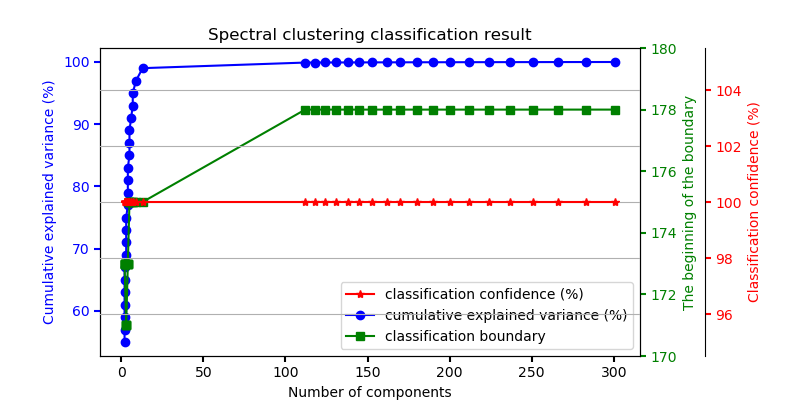

In [54]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots(figsize=(8,4))
fig.subplots_adjust(right=0.8)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.12))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(N_Compents, Explained_variance *100,'bo-',color='blue',label='cumulative explained variance (%)')
p2, = par1.plot(N_Compents, Amb_0,'gs-',color='green',label='classification boundary')
p1_1, = par2.plot(N_Compents, Glo_acc,'*-',color='red',label='classification confidence (%)')

host.set_xlabel("Number of components")
host.set_ylabel("Cumulative explained variance (%)")
par1.set_ylabel("The beginning of the boundary")
par2.set_ylabel("Classification confidence (%)")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p1_1.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p1_1.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

par1.set_ylim(170,180)

lines = [p1_1,p1, p2]

host.legend(lines, [l.get_label() for l in lines],loc='below right')
plt.title('Spectral clustering classification result')
plt.grid(True)
plt.savefig(save_figures_to+"Spectral clustering classification result.svg")